In [1]:
import cv2
import time
import random
import os

In [2]:
def record_and_extract_frame(
    duration_seconds=5,
    camera_index=0,
    output_dir_original="original_capture",
    video_filename_prefix="original_video",
    image_filename_prefix="original_frame",
):
   
    if not os.path.exists(output_dir_original):
        try:
            os.makedirs(output_dir_original)
            print(f"Created directory for originals: {output_dir_original}")
        except OSError as e:
            print(f"Error creating directory {output_dir_original}: {e}")
            return None, None

    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        print(f"Error: Could not open camera at index {camera_index}.")
        return None, None

    # --- 3. Get Video Properties from Camera ---
    actual_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    actual_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0.0 or fps > 120: # Handle unreliable FPS readings
        fps = 20.0
        cap.set(cv2.CAP_PROP_FPS, fps) # Attempt to set a reasonable FPS
        fps = cap.get(cv2.CAP_PROP_FPS) # Re-read
        if fps == 0.0: fps = 20.0 # Fallback if setting failed
        print(f"Camera FPS adjusted/set to: {fps:.2f} FPS")
    else:
        print(f"Camera native FPS: {fps:.2f} FPS")
    print(f"Camera native resolution: {actual_width}x{actual_height}")

    # --- 4. Setup Video Writer for Original Video ---
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    original_video_filename = (
        f"{video_filename_prefix}_{timestamp}_{actual_width}x{actual_height}.mp4"
    )
    original_video_filepath = os.path.join(
        output_dir_original, original_video_filename
    )

    fourcc = cv2.VideoWriter_fourcc(*"mp4v") # MP4 codec
    out_original = cv2.VideoWriter(
        original_video_filepath, fourcc, fps, (actual_width, actual_height)
    )

    if not out_original.isOpened():
        print(f"Error: Could not open video writer for {original_video_filepath}")
        cap.release()
        return None, None

    print(f"Recording original video for {duration_seconds} seconds...")
    start_time = time.time()
    frames_written = 0

    # --- 5. Record Original Video ---
    while (time.time() - start_time) < duration_seconds:
        ret, frame = cap.read()
        if not ret:
            print("Error: Can't receive frame from camera.")
            break
        out_original.write(frame)
        frames_written += 1
        cv2.imshow(f"Recording Original ({actual_width}x{actual_height}) - Press 'q' to stop", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            print("Original recording stopped early by user.")
            break
    
    elapsed_time = time.time() - start_time
    print(f"Original recording finished. Duration: {elapsed_time:.2f}s. Frames: {frames_written}")

    cap.release()
    out_original.release()
    cv2.destroyAllWindows()

    if frames_written == 0:
        print("Error: No frames written to original video.")
        if os.path.exists(original_video_filepath): os.remove(original_video_filepath)
        return None, None

    # --- 6. Extract and Save a Random Frame from Original Video ---
    print(f"Extracting random frame from {original_video_filepath}...")
    cap_read = cv2.VideoCapture(original_video_filepath)
    if not cap_read.isOpened():
        print(f"Error: Could not open {original_video_filepath} for frame extraction.")
        return os.path.abspath(original_video_filepath), None

    total_frames = int(cap_read.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print(f"Error: Original video {original_video_filepath} has 0 frames.")
        cap_read.release()
        return os.path.abspath(original_video_filepath), None

    random_frame_index = random.randint(0, max(0, total_frames - 1))
    cap_read.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)
    ret_frame, frame_to_save = cap_read.read()
    cap_read.release()

    if not ret_frame:
        print(f"Error: Could not read frame {random_frame_index} from original video.")
        return os.path.abspath(original_video_filepath), None

    image_filename = (
        f"{image_filename_prefix}_{timestamp}_frame{random_frame_index}.jpg"
    )
    image_filepath = os.path.join(output_dir_original, image_filename)
    try:
        cv2.imwrite(image_filepath, frame_to_save)
        print(f"Saved random frame as {image_filepath}")
        return os.path.abspath(original_video_filepath), os.path.abspath(image_filepath)
    except Exception as e:
        print(f"Error saving image {image_filepath}: {e}")
        return os.path.abspath(original_video_filepath), None

In [3]:
def rescale_video(
    input_video_path,
    target_width=1280,
    target_height=720,
    output_dir_rescaled="rescaled_videos",
    rescaled_video_prefix="rescaled_video",
):
    print(f"\n--- Starting Video Rescaling for {input_video_path} ---")
    if not os.path.exists(input_video_path):
        print(f"Error: Input video not found at {input_video_path}")
        return None

    # --- 1. Setup Output Directory for Rescaled Video ---
    if not os.path.exists(output_dir_rescaled):
        try:
            os.makedirs(output_dir_rescaled)
            print(f"Created directory for rescaled videos: {output_dir_rescaled}")
        except OSError as e:
            print(f"Error creating directory {output_dir_rescaled}: {e}")
            return None

    # --- 2. Open Input Video ---
    cap_in = cv2.VideoCapture(input_video_path)
    if not cap_in.isOpened():
        print(f"Error: Could not open input video {input_video_path}")
        return None

    # --- 3. Get Properties from Input Video ---
    original_fps = cap_in.get(cv2.CAP_PROP_FPS)
    if original_fps == 0: # Fallback if FPS is not readable
        original_fps = 20.0
        print("Warning: Could not read FPS from input video, using 20.0 FPS for output.")
    
    total_frames = int(cap_in.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Input video FPS: {original_fps:.2f}, Total Frames: {total_frames}")
    print(f"Rescaling to: {target_width}x{target_height}")

    # --- 4. Setup Video Writer for Rescaled Video ---
    # Use a timestamp from the original filename if possible, or a new one
    base_filename = os.path.basename(input_video_path)
    timestamp_match = time.strftime("%Y%m%d_%H%M%S") # Default to current
    # Try to extract timestamp from original name for consistency
    parts = base_filename.split('_')
    if len(parts) > 2 and parts[1].isdigit() and len(parts[1]) == 8 and parts[2].isdigit() and len(parts[2]) == 6:
        timestamp_match = f"{parts[1]}_{parts[2]}"


    rescaled_video_filename = (
        f"{rescaled_video_prefix}_{timestamp_match}_{target_width}x{target_height}.mp4"
    )
    rescaled_video_filepath = os.path.join(
        output_dir_rescaled, rescaled_video_filename
    )

    fourcc = cv2.VideoWriter_fourcc(*"mp4v") # MP4 codec
    out_rescaled = cv2.VideoWriter(
        rescaled_video_filepath,
        fourcc,
        original_fps, # Use original FPS for consistent speed
        (target_width, target_height),
    )

    if not out_rescaled.isOpened():
        print(f"Error: Could not open video writer for {rescaled_video_filepath}")
        cap_in.release()
        return None

    print(f"Rescaling and saving to {rescaled_video_filepath}...")
    frames_processed = 0
    # --- 5. Read, Resize, and Write Frames ---
    while True:
        ret, frame = cap_in.read()
        if not ret:
            break # End of video or error

        resized_frame = cv2.resize(
            frame, (target_width, target_height), interpolation=cv2.INTER_AREA
        )
        out_rescaled.write(resized_frame)
        frames_processed += 1
        if frames_processed % 100 == 0: # Progress update
            print(f"Processed {frames_processed}/{total_frames} frames for rescaling...")


    print(f"Rescaling finished. Processed {frames_processed} frames.")

    # --- 6. Release Resources ---
    cap_in.release()
    out_rescaled.release()
    cv2.destroyAllWindows() # Just in case any were left open

    if frames_processed == 0:
        print("Error: No frames processed for rescaling.")
        if os.path.exists(rescaled_video_filepath): os.remove(rescaled_video_filepath)
        return None
        
    return os.path.abspath(rescaled_video_filepath)

In [4]:
if __name__ == "__main__":
    # --- Configuration ---
    recording_duration = 10  # Seconds, use 45 for your requirement
    camera_device_index = 0

    original_files_directory = "media_capture_original"
    original_video_prefix = "my_native_video"
    original_frame_prefix = "my_native_frame"

    rescaled_files_directory = "media_capture_1280x720"
    rescaled_video_prefix = "my_rescaled_video"
    target_rescale_width = 1280
    target_rescale_height = 720

    # --- Step 1: Record original video and extract a frame ---
    original_video_path, random_frame_path = record_and_extract_frame(
        duration_seconds=recording_duration,
        camera_index=camera_device_index,
        output_dir_original=original_files_directory,
        video_filename_prefix=original_video_prefix,
        image_filename_prefix=original_frame_prefix,
    )

    rescaled_video_path = None
    if original_video_path:
        print(f"\nOriginal video saved to: {original_video_path}")
        if random_frame_path:
            print(f"Random frame from original saved to: {random_frame_path}")
        else:
            print("Failed to extract/save random frame from original video.")

        # --- Step 2: Rescale the original video ---
        rescaled_video_path = rescale_video(
            input_video_path=original_video_path,
            target_width=target_rescale_width,
            target_height=target_rescale_height,
            output_dir_rescaled=rescaled_files_directory,
            rescaled_video_prefix=rescaled_video_prefix,
        )
        if rescaled_video_path:
            print(f"\nRescaled video (1280x720) saved to: {rescaled_video_path}")
        else:
            print("\nVideo rescaling failed.")
    else:
        print("\nOriginal video recording failed. Cannot proceed to rescaling.")

    print("\n--- Script Finished ---")
    print(f"Returned paths:")
    print(f"  Original Video: {original_video_path}")
    print(f"  Random Frame:   {random_frame_path}")
    print(f"  Rescaled Video: {rescaled_video_path}")

Created directory for originals: media_capture_original
Camera native FPS: 30.00 FPS
Camera native resolution: 640x480
Recording original video for 10 seconds...
Original recording finished. Duration: 10.03s. Frames: 284
Extracting random frame from media_capture_original\my_native_video_20250530_010437_640x480.mp4...
Saved random frame as media_capture_original\my_native_frame_20250530_010437_frame116.jpg

Original video saved to: c:\Users\user\Documents\dev\SurfWatch\IOT\media_capture_original\my_native_video_20250530_010437_640x480.mp4
Random frame from original saved to: c:\Users\user\Documents\dev\SurfWatch\IOT\media_capture_original\my_native_frame_20250530_010437_frame116.jpg

--- Starting Video Rescaling for c:\Users\user\Documents\dev\SurfWatch\IOT\media_capture_original\my_native_video_20250530_010437_640x480.mp4 ---
Created directory for rescaled videos: media_capture_1280x720
Input video FPS: 30.00, Total Frames: 284
Rescaling to: 1280x720
Rescaling and saving to media_capt

In [5]:
import cv2
from IPython.display import display, Image, clear_output
import time # Optional: for controlling frame rate slightly

def show_webcam_jupyter():
    # Attempt to capture video from the default camera (index 0)
    # If you have multiple cameras, you might need to change this to 1, 2, etc.
    cap = cv2.VideoCapture(0)

    # Check if the webcam is opened correctly
    if not cap.isOpened():
        print("Error: Could not open video device.")
        return

    print("Webcam feed started. To stop, interrupt the kernel (Kernel > Interrupt).")

    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()

            # if frame is read correctly ret is True
            if not ret:
                print("Error: Can't receive frame (stream end?). Exiting ...")
                break

            # Convert the frame to JPEG format
            # The first return value of imencode is a success flag,
            # the second is the encoded image.
            _, jpg_data = cv2.imencode('.jpg', frame)

            # Create an IPython Image object from the JPEG data
            img = Image(data=jpg_data.tobytes())

            # Clear the previous output and display the new frame
            clear_output(wait=True)
            display(img)

            # Optional: Add a small delay to control frame rate
            # time.sleep(0.03) # Roughly 30 FPS

    except KeyboardInterrupt:
        print("Stream stopped by user (KeyboardInterrupt).")
    finally:
        # When everything done, release the capture
        if cap.isOpened():
            cap.release()
        print("Webcam released.")
        # No cv2.destroyAllWindows() needed as we are not using cv2.imshow()

# To run this in a Jupyter Notebook cell, simply call the function:
# show_webcam_jupyter()

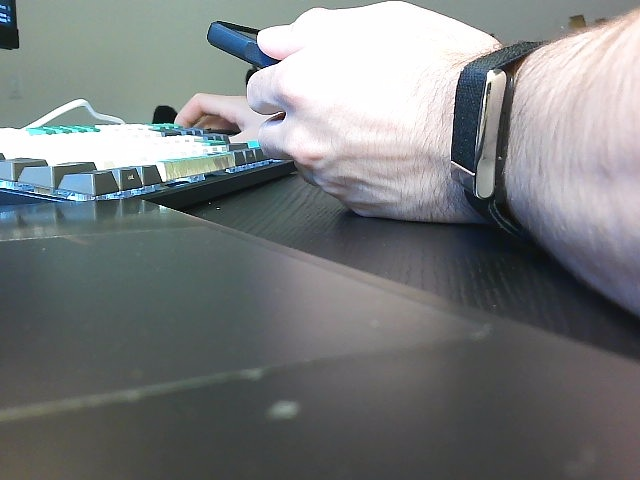

Stream stopped by user (KeyboardInterrupt).
Webcam released.


In [6]:
show_webcam_jupyter()